# Taller de supervisado de enfermedades coronarias en Sudáfrica

El objetivo de este taller es tener un acercamiento a los modelos de clasificación de regresión logística y K-NN, utilizando como caso de estudio una población sudafricana con alto riesgo de enfermedad coronaria. El dataset, que en cada registro presenta un individuo hombre, incluye las siguientes variables:

- sbp: presión sanguínea sistólica
- tobacco: cantidad de tabaco acumulada (en kg)
- ldl: colesterol de lipoproteinas de baja densidad
- adiposity: grado de tejido adiposo
- famhist: indica si la familia del individuo tiene historia de enfermedades coronarias (“Present”) o no (“Absent”)
- typea: comportamiento tipo A
- obesidad: grado de obesidad
- alcohol: consumo de alcohol actual
- age: edad
- chd: variable objetivo que indica si el individuo tiene enfermedad coronaria sí (1) o no (0)

# 0. Librerías a importar

In [ ]:
#! pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors, metrics
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# 1. Cargar, explorar y preparar el dataset

In [4]:
corazon = pd.read_csv('03-SAHeartDisease.csv')
corazon.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [5]:
corazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   row.names  462 non-null    int64  
 1   sbp        462 non-null    int64  
 2   tobacco    462 non-null    float64
 3   ldl        462 non-null    float64
 4   adiposity  462 non-null    float64
 5   famhist    462 non-null    object 
 6   typea      462 non-null    int64  
 7   obesity    462 non-null    float64
 8   alcohol    462 non-null    float64
 9   age        462 non-null    int64  
 10  chd        462 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 39.8+ KB


In [6]:
corazon.describe(include='all')

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462,462.000000,462.000000,462.000000,462.000000,462.000000
unique,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Absent,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,270,NaN,NaN,NaN,NaN,NaN
mean,231.935065,138.326840,3.635649,4.740325,25.406732,NaN,53.103896,26.044113,17.044394,42.816017,0.346320
std,133.938585,20.496317,4.593024,2.070909,7.780699,NaN,9.817534,4.213680,24.481059,14.608956,0.476313
min,1.000000,101.000000,0.000000,0.980000,6.740000,NaN,13.000000,14.700000,0.000000,15.000000,0.000000
25%,116.250000,124.000000,0.052500,3.282500,19.775000,NaN,47.000000,22.985000,0.510000,31.000000,0.000000
50%,231.500000,134.000000,2.000000,4.340000,26.115000,NaN,53.000000,25.805000,7.510000,45.000000,0.000000
75%,347.750000,148.000000,5.500000,5.790000,31.227500,NaN,60.000000,28.497500,23.892500,55.000000,1.000000


In [7]:
corazon.select_dtypes(include='number').quantile(np.arange(0,1,0.1))

,row.names,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
0.0,1.0,101.0,0.000,0.980,6.740,13.0,14.700,0.000,15.0,0.0
0.1,47.1,118.0,0.000,2.510,13.713,41.0,21.142,0.000,18.0,0.0
0.2,93.2,122.0,0.000,3.104,17.930,46.0,22.320,0.000,28.0,0.0
0.3,139.3,126.0,0.400,3.543,21.145,49.0,23.633,1.385,34.0,0.0
0.4,185.4,130.0,1.024,3.950,23.874,51.0,24.804,3.248,40.0,0.0
0.5,231.5,134.0,2.000,4.340,26.115,53.0,25.805,7.510,45.0,0.0
0.6,278.6,138.0,3.436,4.890,28.082,56.0,26.706,11.830,49.0,0.0
0.7,324.7,144.0,4.500,5.457,30.057,58.0,27.807,19.298,54.0,1.0
0.8,370.8,154.0,6.156,6.138,32.472,61.0,29.114,27.770,58.0,1.0
0.9,416.9,166.0,9.090,7.383,35.352,65.0,30.965,47.510,61.0,1.0


In [8]:
corazon.describe(include=['O'])

,famhist
count,462
unique,2
top,Absent
freq,270


In [7]:
corazon['chd'].value_counts()

chd
0    302
1    160
Name: count, dtype: int64

In [10]:
tab = corazon['chd'].value_counts()
tab/tab.sum()

chd
0    0.65368
1    0.34632
Name: count, dtype: float64

### PREGUNTA: 

¿Qué ven de particular en los datos?


Por un lado encontramos que la variable objetivo no está completamente balanceada (65% vs 35% de proporciones para las dos categorías). La diferencia no es, en todo caso, grave, pues hay una gran proporción de la clase minoritaria


In [11]:
corazon

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1
...,...,...,...,...,...,...,...,...,...,...,...
457,459,214,0.40,5.98,31.72,Absent,64,28.45,0.00,58,0
458,460,182,4.20,4.41,32.10,Absent,52,28.61,18.72,52,1
459,461,108,3.00,1.59,15.23,Absent,40,20.09,26.64,55,0
460,462,118,5.40,11.61,30.79,Absent,64,27.35,23.97,40,0


In [12]:
print(f"Min ldl: {corazon['ldl'].min()}, Max ldl: {corazon['ldl'].max()}")
print(f"Min sbp: {corazon['sbp'].min()}, Max sbp: {corazon['sbp'].max()}")

Min ldl: 0.98, Max ldl: 15.33
Min sbp: 101, Max sbp: 218


También vemos que las escalas de las variables numéricas son bien diferentes, con variables como ldl que van de 0.98 a 15.3 y otras como sbp que van de 101 a 218. Esto implica que, con modelos sensibles a las escalas como K-NN, es necesario reescalar los valores de las variables, para que todas tengan la misma importancia en los modelos finales. En el caso de la regresión logística, el modelo no es sensible a la escala, pero los coeficientes de las variables predictivas no podrán ser comparados directamente para entender las variables mas sensibles en la predicción de la variable dependiente.

Vamos a estandarizar los datos para poder aplicar el modelo K-nn sin problemas, y poder interpretar más fácilmente los coeficientes del modelo de regresión logística.

In [13]:
vars = corazon.columns
numericVars = corazon.select_dtypes(include='number')
categoricalVars = corazon.select_dtypes(include='object')
numericVars[numericVars.columns] = StandardScaler().fit_transform(numericVars)
corazonStd = pd.concat([numericVars,categoricalVars], axis=1)
corazonStd.describe()

,row.names,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,462.000000,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02
mean,0.000000,-1.384174e-16,-2.210834e-17,3.421986e-16,1.807116e-16,-9.227828e-17,5.978863e-16,2.153160e-16,-9.612321e-18,-3.844928e-18
std,1.001084,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00
min,-1.726055,-1.823123e+00,-7.924170e-01,-1.817753e+00,-2.401708e+00,-4.089354e+00,-2.695129e+00,-6.969825e-01,-1.906103e+00,-7.278745e-01
25%,-0.864654,-6.997535e-01,-7.809742e-01,-7.047170e-01,-7.245926e-01,-6.224081e-01,-7.267824e-01,-6.761275e-01,-8.096968e-01,-7.278745e-01
50%,-0.003252,-2.113321e-01,-3.565020e-01,-1.935182e-01,9.112757e-02,-1.059418e-02,-5.680824e-02,-3.898822e-01,1.496582e-01,-7.278745e-01
75%,0.865624,4.724579e-01,4.063492e-01,5.074164e-01,7.489145e-01,7.031887e-01,5.828745e-01,2.800340e-01,8.349118e-01,1.373863e+00
max,1.727026,3.891408e+00,6.007857e+00,5.119082e+00,2.197976e+00,2.538631e+00,4.878906e+00,5.321938e+00,1.451640e+00,1.373863e+00


Vamos ahora a explorar las distribuciones de los valores de las variables numéricas del dataset a partir de un diagrama de boxplot:

<Axes: >

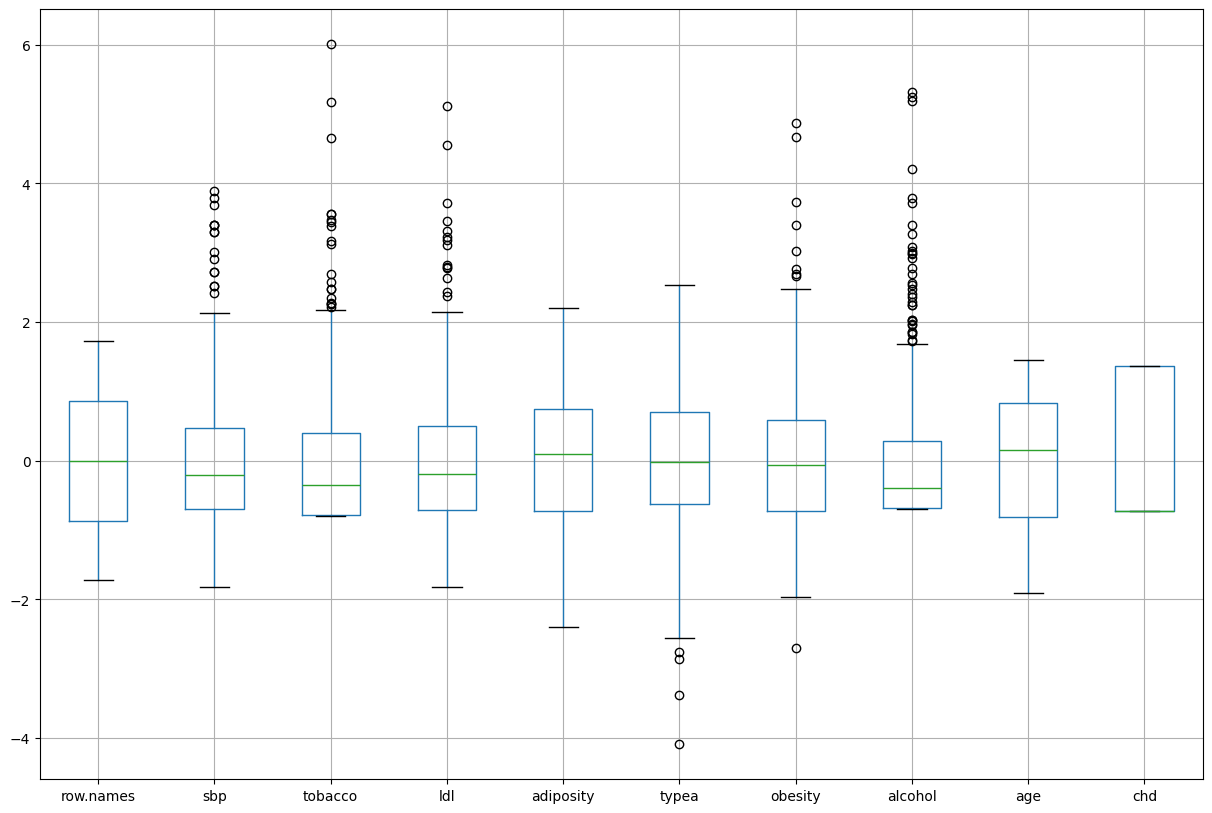

In [14]:
corazonStd[numericVars.columns].boxplot(figsize=(15,10))

Encontramos que hay valores excepcionales pero no consideramos que sean anómalos, por lo que no eliminamos registros.

Podemos tratar de entender la influencia de cada variable predictiva en la predicción de la variable objetivo, de manera aislada e independiente de las otras variables, a partir de un plot de densidad. Visualicemos la distribución de los valores de la variable age para los individuos con y sin problemas cardiacos:

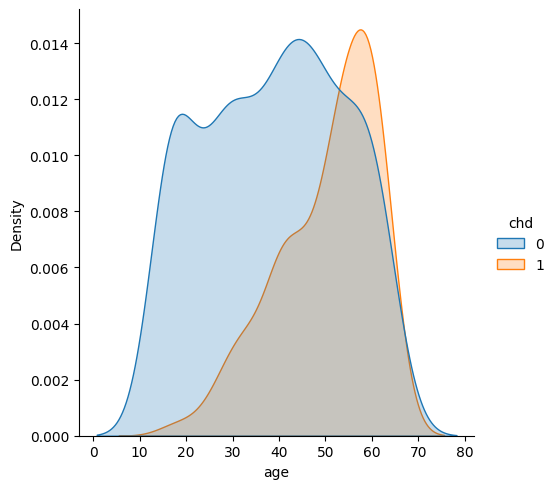

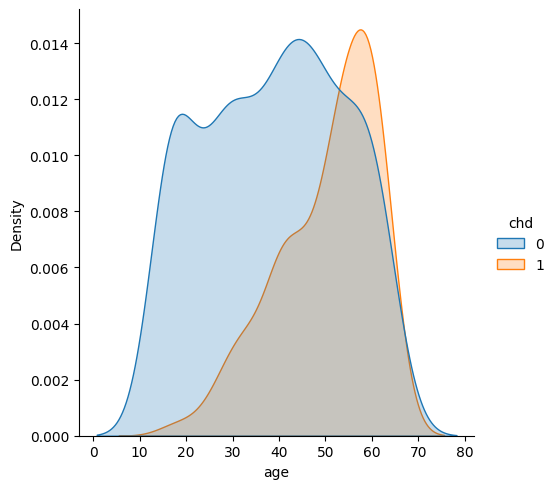

In [18]:
sns.displot(corazon,x='age',hue='chd',kind='kde',fill=True)
plt.show()

En el gráfico anterior podemos ver que las personas de mayor edad son más propensas a desarrollar enfermedades cardíacas

Veamos como se comporta la variable tobacco:

<Figure size 1600x400 with 0 Axes>

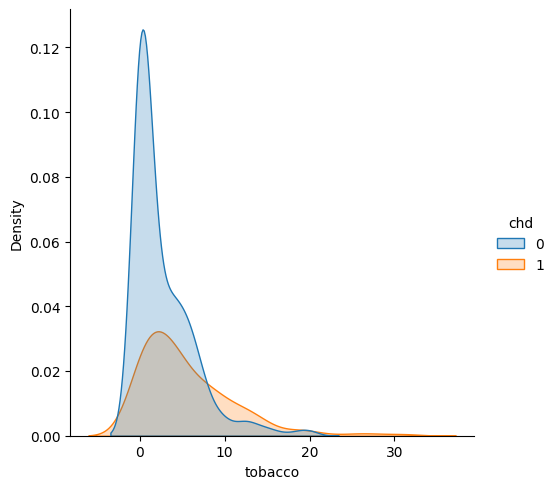

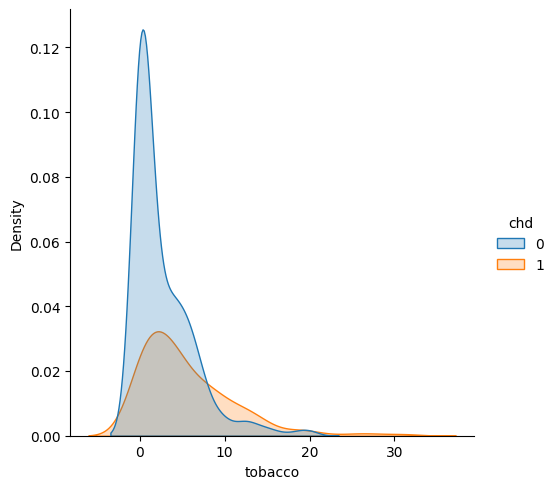

In [20]:
sns.displot(corazon,x='tobacco',hue='chd',kind='kde',fill=True)
plt.show()

Vemos que las personas que consumen muy poco tabaco son muchísimo menos propensas a desarrollar enfermedades cardiacas, y vicecersa.

# 2. Modelo de regresión logística

Vale la pena recalcar el hecho de que no vamos a seguir aún ningún protocolo de evaluación que permita obtener una idea clara de las capacidades de generalización del modelo a datos diferentes a los del dataset de entrenamiento: vamos a entrenar y a evaluar el modelo sobre el mismo dataset.

Utilizaremos el LogisticRegression del paquete sklearn. Algunos de los parámetros del método son los siguientes:
- penalty: término de fenalización para realizar regularización.
- fit_intercept: para especificar si una constante (el intercepto o sesgo) se debe añadir a la función
- random_state: establece la semilla al generador aleatorio de tal manera que los resultados sean deterministas (se puedan replicar)
- solver: algoritmo a utilizarse en el problema de optimización

Vamos a entrenar un primer modelo de regresión logística sobre el dataset, utilizando solamente la variable ldl, sobre el dataset sin estandarizar:

Para ello haremos uso de la función fit a la cual le pasaremos una matriz de forma (n,m), donde n es la cantidad de muestras y m la cantidad de predictores, y un vector de etiquetas de forma (n,).

Además, podemos ver los coeficientes asociados a cada variable predictiva. En este caso hay una sola variable predictiva, ldl, que presenta un coeficiente de 0.2739.


In [21]:
X1 = pd.DataFrame(corazon['ldl'])
y = corazon['chd']
logReg1 = LogisticRegression(random_state=0).fit(X1,y)
logReg1.coef_[0][0]

np.float64(0.2739270311834588)

Para poder realizar las predicciones se utiliza el método predict. Se recibe como parámetro la matriz de variables independientes, aunque en este caso tan solo involucra la variable independiente ldl.

Se pueden observar las primeras 5 predicciones.

In [22]:
preds1 = logReg1.predict(X1)
preds1[0:5]

array([0, 0, 0, 0, 0])

Con el método predict_proba obtenemos la probabilidad de pertenecer a cada categoría de la clase. En este caso particular podemos observar la probabilidad de que el resultado sea Si

In [24]:
preds1_prob = logReg1.predict_proba(X1)
preds1_prob[0:5,1]

array([0.40238712, 0.31927355, 0.26661514, 0.44787552, 0.26768774])

Con el método score obtenemos la exactitud o accuracy de nuestro modelo, en este caso el 66.6%

In [23]:
logReg1.score(X1,y)

0.6666666666666666

En este caso, en vez de utilizar la variable ldl para implementar nuestro modelo, lo hacemos con age

In [25]:
X2 = pd.DataFrame(corazon['age'])
logReg2 = LogisticRegression(random_state=0).fit(X2,y)
preds2 = logReg2.predict(X2)
preds2[0:5]

array([0, 1, 0, 1, 0])

In [26]:
preds2_prob = logReg2.predict_proba(X2)
preds2_prob[0:5,1]

array([0.45310996, 0.62645127, 0.36060661, 0.54896913, 0.40602498])

Se tiene un mejor ajuste de acuerdo con el nivel de accuracy 67.96%

In [27]:
logReg2.score(X2,y)

0.6796536796536796

Utilizamos en este caso todas las variables numéricas para implementar el modelo.

In [28]:
X3 = pd.DataFrame(corazon[numericVars.columns])
y = corazon['chd']
logReg3 = LogisticRegression(random_state=0).fit(X3,y)
preds3 = logReg3.predict(X3)
preds3[0:5]

array([1, 1, 0, 1, 1])

In [29]:
preds3_prob = logReg3.predict_proba(X3)
preds3_prob[0:5,1]

array([0.99784557, 0.88426121, 0.00358005, 0.9686369 , 0.98122108])

Se obtiene un accuracy del 72.29%

In [30]:
logReg3.score(X3,y)

0.9826839826839827

Utilizamos el conjunto de datos estandarizado con todas las variables numéricas

In [31]:
X4 = pd.DataFrame(corazonStd[numericVars.columns])
y = corazon['chd']
logReg4 = LogisticRegression(random_state=0).fit(X4,y)
preds4 = logReg4.predict(X4)
preds4[0:5]

array([1, 1, 0, 1, 1])

In [32]:
preds4_prob = logReg4.predict_proba(X4)
preds4_prob[0:5,1]

array([0.99181676, 0.9882288 , 0.00605053, 0.99208608, 0.9909652 ])

El nivel de exactitud es un poco mejor con un 72.51%

In [33]:
logReg4.score(X4,y)

1.0

# 3. Modelo KNN

Vamos a utilizar ahora el KNeighborsClassifier de sklearn. Algunos parámetros de este método son:

- n_neighbors: la cantidad de vecinos a utilizar para realizar la predicción
- algorithm: algoritmo utilizado para computar los vecinos más cercanos
- metric: métrica para establecer la distancia entre las observaciones

Vamos a entrenar un primer modelo de KNN sobre el dataset sin estandarizar. Hay que tener en cuenta que la variable famhist es categórica con dos variables, por lo que no la vamos a tener en cuenta.

Vamos a considerar las primeras 362 instancias como set de entrenamieno y las últimas como set de test. Cuidado: esto se puede hacer cuando se sabe que los datos no están ordenados. Separamos las variables predictivas de la objetivo.

In [34]:
corazon.shape
corazon.columns

Index(['row.names', 'sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea',
       'obesity', 'alcohol', 'age', 'chd'],
      dtype='object')

In [35]:
train_X = corazon.iloc[0:362, [0,1,2,3,4,6,7,8]]
train_y = corazon.iloc[0:362, 9]

In [36]:
test_X = corazon.iloc[362:, [0,1,2,3,4,6,7,8]]
test_y = corazon.iloc[362:, 9]

Vamos ahora a predecir la clase de las instancias del test set, utilizando el modelo knn con k=5 y a compararlas con las clases reales, usando un valor de K=5

In [37]:
k = 5 
knn = neighbors.KNeighborsClassifier(n_neighbors=k) 
knn.fit(train_X,train_y) 
preds_y = knn.predict(test_X)
coincidencias = 0
for i in range(len(preds_y)):
    if(preds_y[i] ==  test_y.values[i]):
        coincidencias+=1
print(f"Con k={k} se encontraron {coincidencias} buenas predicciones")

Con k=5 se encontraron 2 buenas predicciones


In [39]:
k = 15 
knn = neighbors.KNeighborsClassifier(n_neighbors=k) 
knn.fit(train_X,train_y) 
preds_y = knn.predict(test_X)
coincidencias = 0
for i in range(len(preds_y)):
    if(preds_y[i] ==  test_y.values[i]):
        coincidencias+=1
print(f"Con k={k} se encontraron {coincidencias} buenas predicciones")

Con k=15 se encontraron 3 buenas predicciones


Vemos que nos va mejor con el modelo que utiliza un parámetro K con valor de 15.